In [1]:
!pip install xgboost optuna seaborn scikit-learn numpy matplotlib

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import FunctionTransformer, Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from xgboost import cv, DMatrix, XGBClassifier

---

# Loading the datasets

Link to the dataset: https://www.kaggle.com/competitions/playground-series-s4e10/data

In [3]:
train_df = pd.read_csv('./datasets/train.csv', index_col=0)
test_df = pd.read_csv('./datasets/test.csv', index_col=0)

# Exploratory Analysis

1. Checking shapes

In [4]:
for df_name, df in [('train', train_df), ('test', test_df)]:
    print(f'{df_name}: {df.shape}')

train: (58645, 12)
test: (39098, 11)


2. Checking dtypes (finding categorical and continuous columns)

In [5]:
train_df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object

- **person_age:** The applicant's age.
- **person_income:** How much money the applicant makes per year.
- **person_home_ownership:** Whether the applicant owns a home or not.
- **person_emp_length:** How many years the applicant has been working.
- **loan_intent:** The reason the applicant needs the loan.
- **loan_grade:** A score showing how reliable the applicant is in paying back loans.
- **loan_amnt:** The amount of money the applicant wants to borrow.
- **loan_int_rate:** The interest rate charged on the loan.
- **loan_percent_income:** What percentage of the applicant's income will go to loan payments.
- **cb_person_default_on_file:** Shows if the applicant has ever failed to pay back a loan.
- **cb_person_cred_hist_length:** How long the applicant has had a credit history
- **loan_status:** Shows if the loan is approved or rejected.

source: https://www.kaggle.com/datasets/chilledwanker/loan-approval-prediction/discussion/538233

3. Choosing the right enconding for each categorical column

In [6]:
for column in ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']:
    print(train_df[column].value_counts())
    print('-'*50)

person_home_ownership
RENT        30594
MORTGAGE    24824
OWN          3138
OTHER          89
Name: count, dtype: int64
--------------------------------------------------
loan_intent
EDUCATION            12271
MEDICAL              10934
PERSONAL             10016
VENTURE              10011
DEBTCONSOLIDATION     9133
HOMEIMPROVEMENT       6280
Name: count, dtype: int64
--------------------------------------------------
loan_grade
A    20984
B    20400
C    11036
D     5034
E     1009
F      149
G       33
Name: count, dtype: int64
--------------------------------------------------
cb_person_default_on_file
N    49943
Y     8702
Name: count, dtype: int64
--------------------------------------------------


- cb_person_default_on_file: Binary encoding (1 column, 0 or 1 for 'Y' and 'N');
- person_home_ownership, loan_intent: OneHot-Encoding, multiple categories (*but not too many) with no distance relation between them;
- loan_grade: Ordinal Encoding, sequential numbers from 0 to 6 (There is a distance relation between each category 'A' is the farthest from 'G').

Looking at this data, we can notice a high imbalance in person_home_ownership and cb_person_default_on_file. We can't do much about the second since it's from the data nature, but in the first case, we can join the 'other' and 'own' categories.

We'll add that to the pipeline later on.

4. Continuous variables

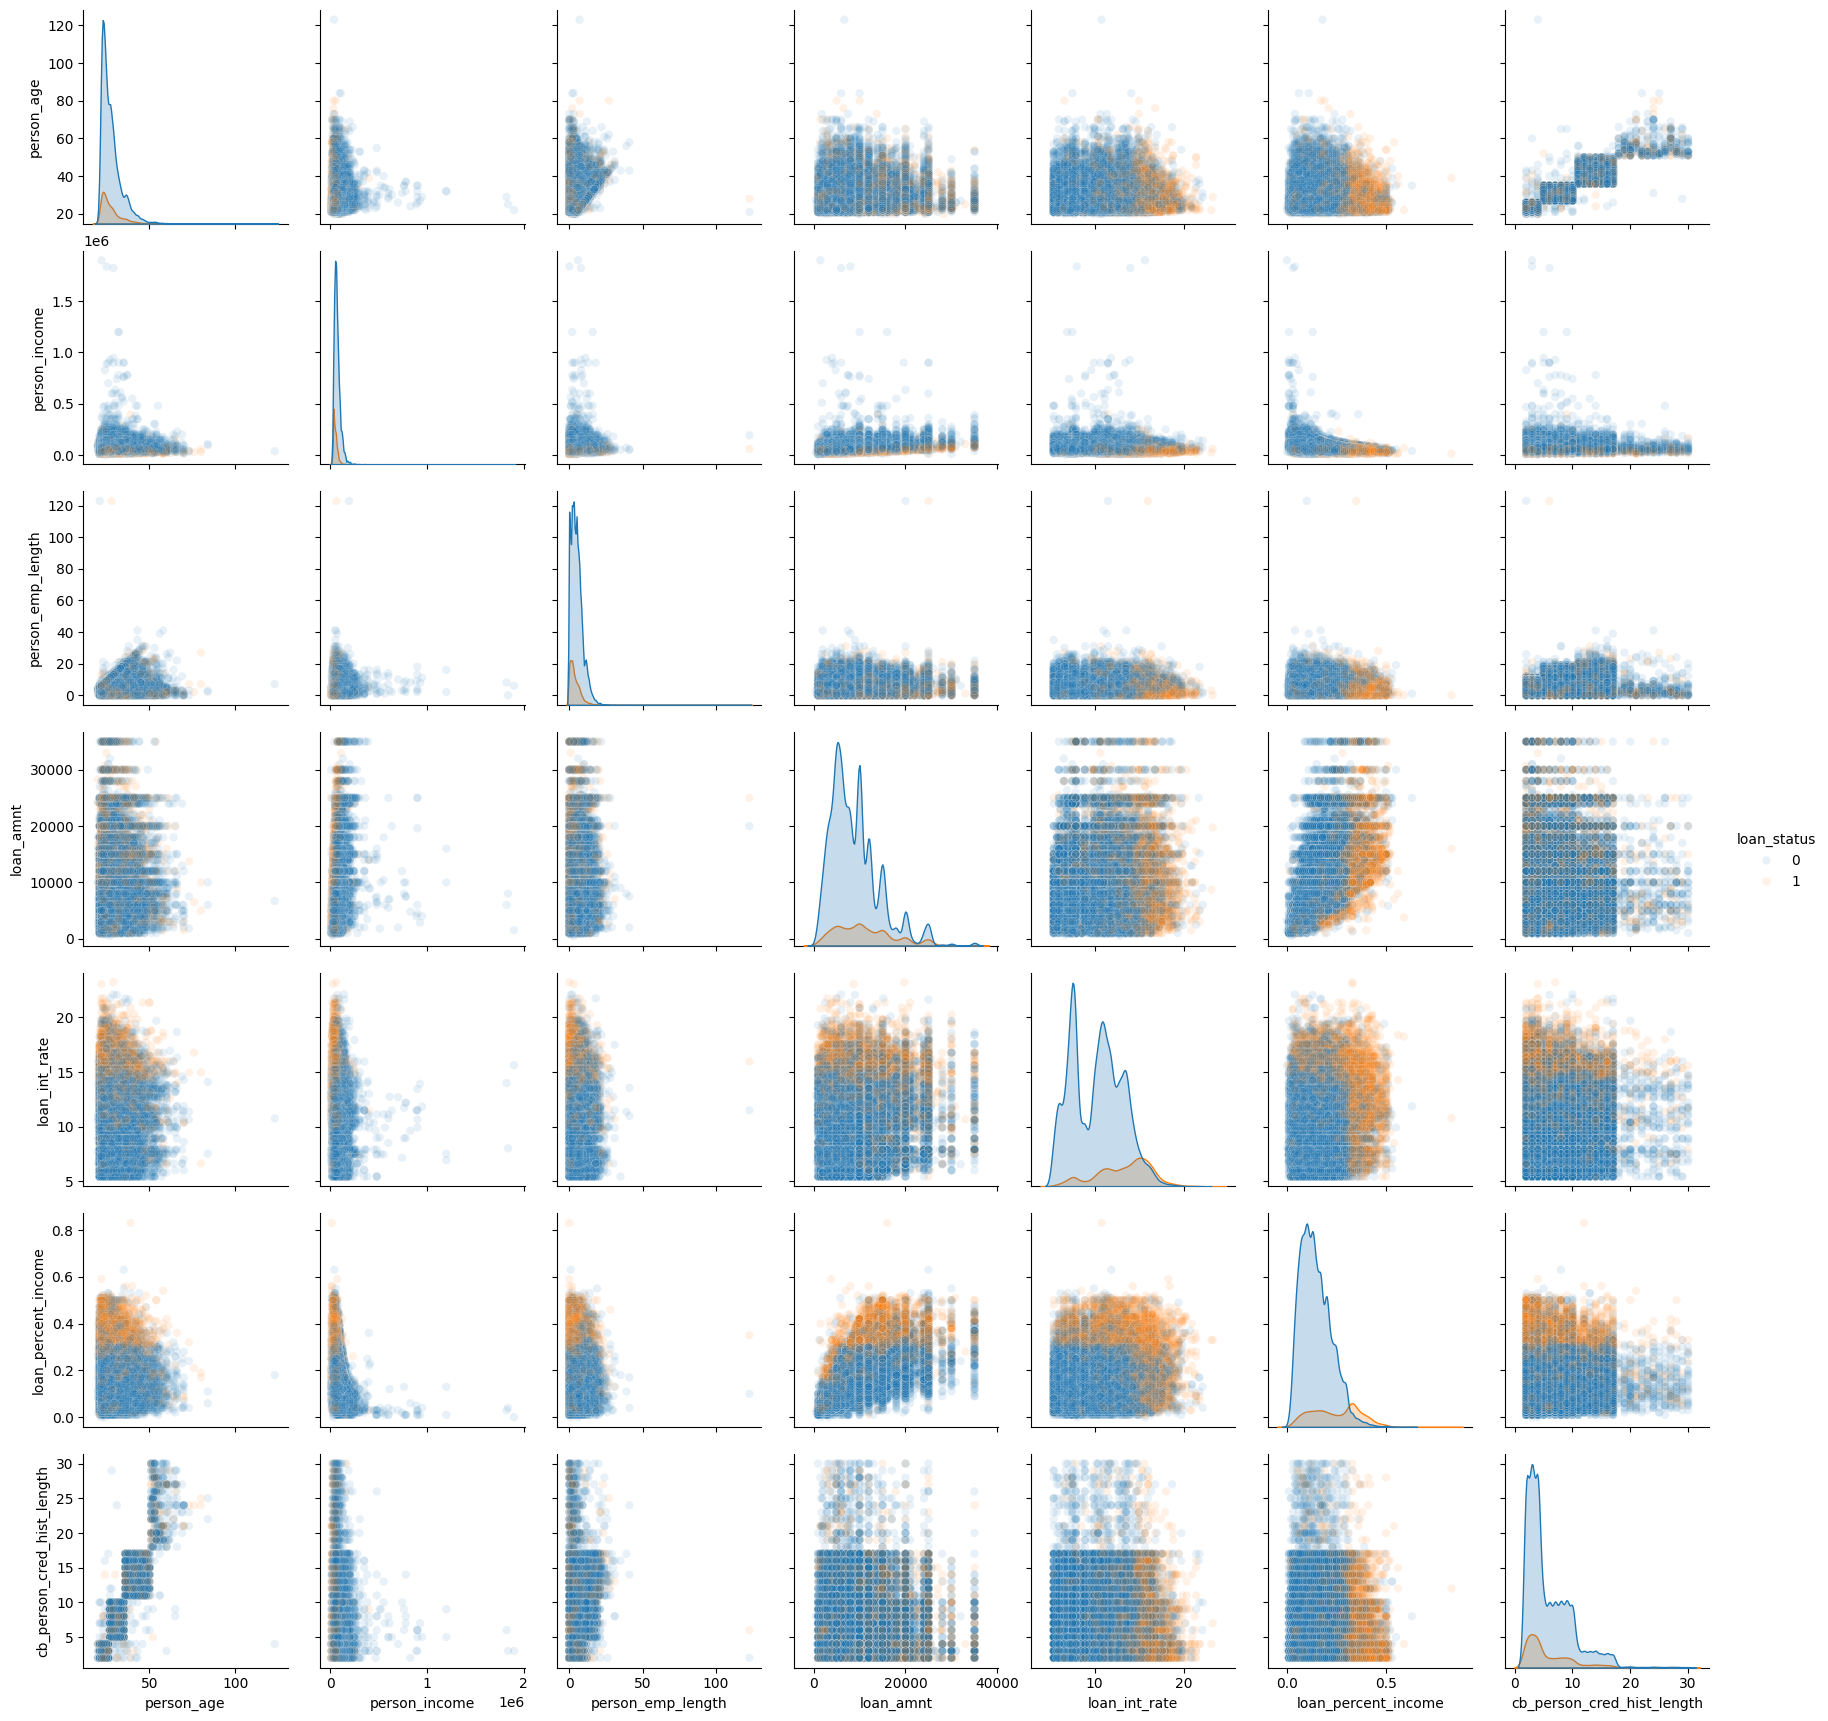

In [7]:
sns.pairplot(
    train_df[['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_status']],
    hue='loan_status',
    plot_kws={'alpha': 0.1},
    )
plt.show()

It looks like the cb_person_cred_hist_length is shaped in steps, people are distributed in groups of <5, 6~10, 11~17, and 18+. If we look at the "person_age" vs "cb_person_cred_hist_length", we can also see a pattern of ages for each of these groups, indicating that people older people tend to have a longer credit history (a little obvious, but this shows that credit history tends to be consistent, there are not that many older people with a small credit history length, as we can see in the histograms below).

C:\Users\12ped\AppData\Local\Temp\ipykernel_29692\3833630432.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df_cp.groupby('cb_person_cred_hist_len_groups').hist('person_age', bins=30)


cb_person_cred_hist_len_groups
<5         [[Axes(0.125,0.11;0.775x0.77)]]
5<x<11     [[Axes(0.125,0.11;0.775x0.77)]]
11<x<18    [[Axes(0.125,0.11;0.775x0.77)]]
>18        [[Axes(0.125,0.11;0.775x0.77)]]
dtype: object

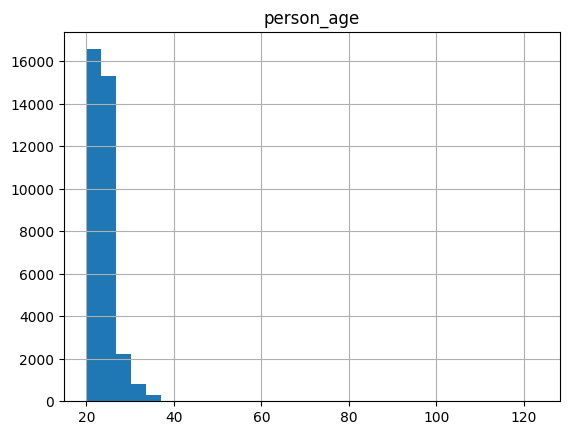

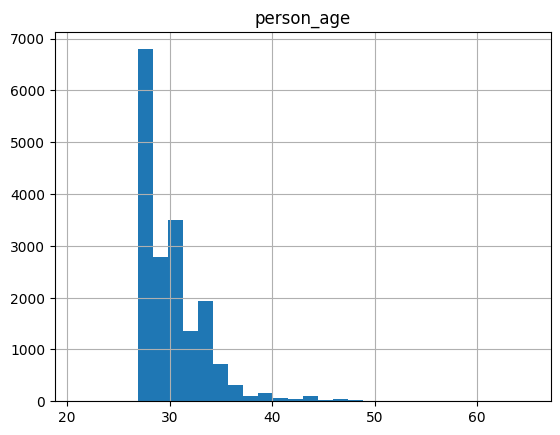

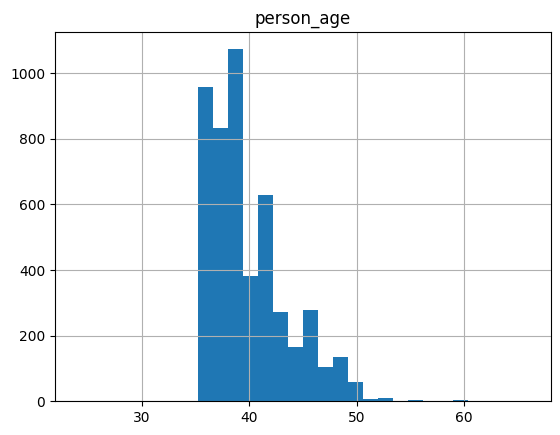

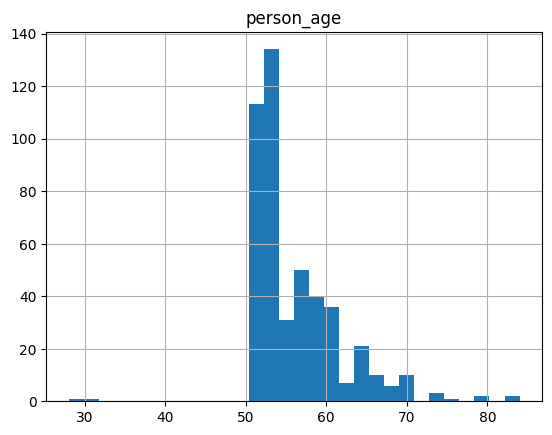

In [8]:
train_df_cp = train_df.copy()
train_df_cp['cb_person_cred_hist_len_groups'] = pd.cut(train_df_cp['cb_person_cred_hist_length'], [0, 5, 11, 18, np.inf], labels=['<5', '5<x<11', '11<x<18', '>18'])#.astype(int)
train_df_cp.groupby('cb_person_cred_hist_len_groups').hist('person_age', bins=30)

Lets explore the age when people start to get credit

<Axes: ylabel='Frequency'>

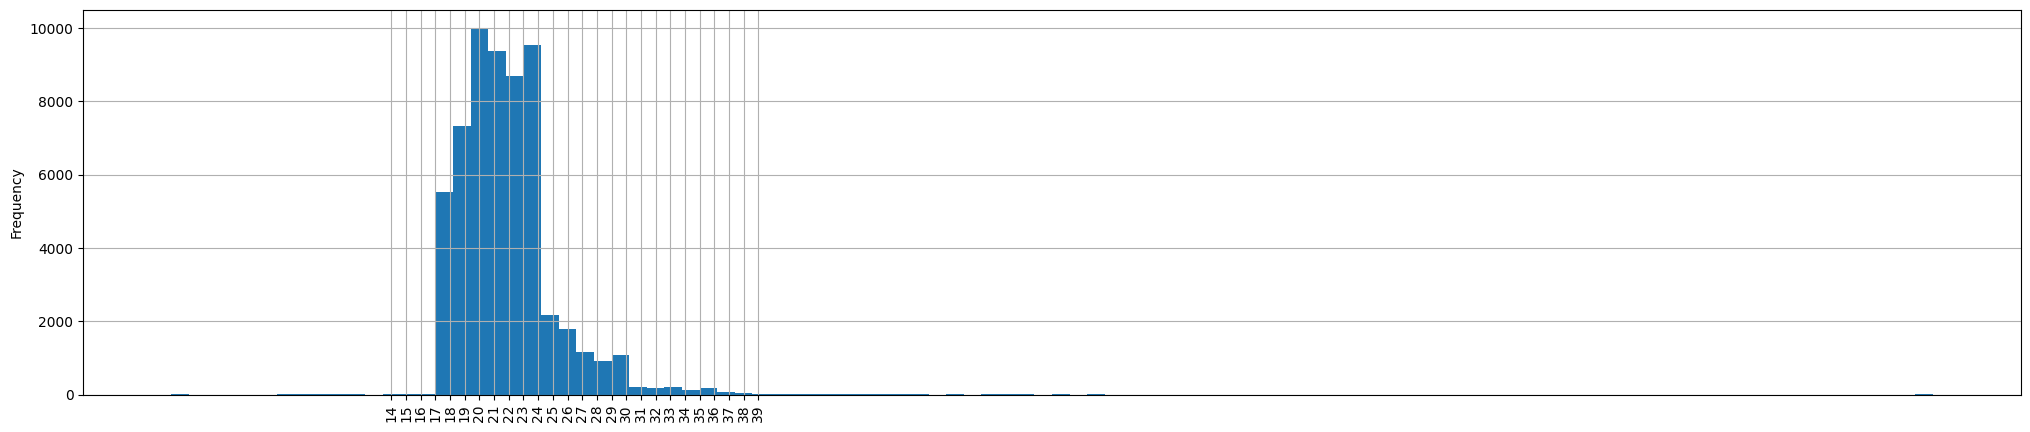

In [9]:
credit_starting_age = train_df_cp['person_age'] - train_df_cp['cb_person_cred_hist_length']
credit_starting_age.plot.hist(bins=100, xticks=range(14, 40), figsize=(25,5), rot=90, grid=True, align='mid')

Looks like most people tend to start a credit history at age 18~25 and not many people start taking credit older than 30. People with age >30 that take a loan mostly have a credit history before that.

# Checking correlations

<Axes: >

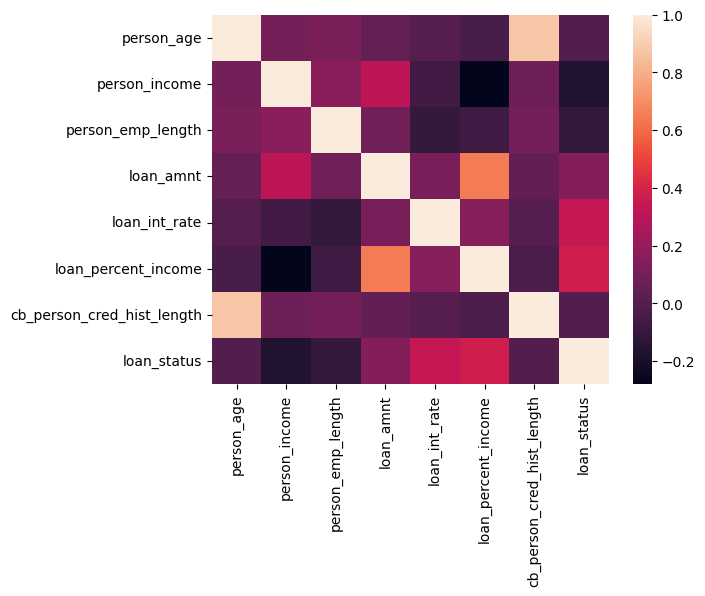

In [10]:
# Correlation matrix
corr = train_df.select_dtypes('number').corr()
sns.heatmap(corr)

In [11]:
# Printing correlations between variables and output
train_df[['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']].corrwith(train_df['loan_status']).sort_values(ascending=False)

loan_percent_income           0.378280
loan_int_rate                 0.338948
loan_amnt                     0.144982
person_age                   -0.001130
cb_person_cred_hist_length   -0.003030
person_emp_length            -0.100428
person_income                -0.169956
dtype: float64

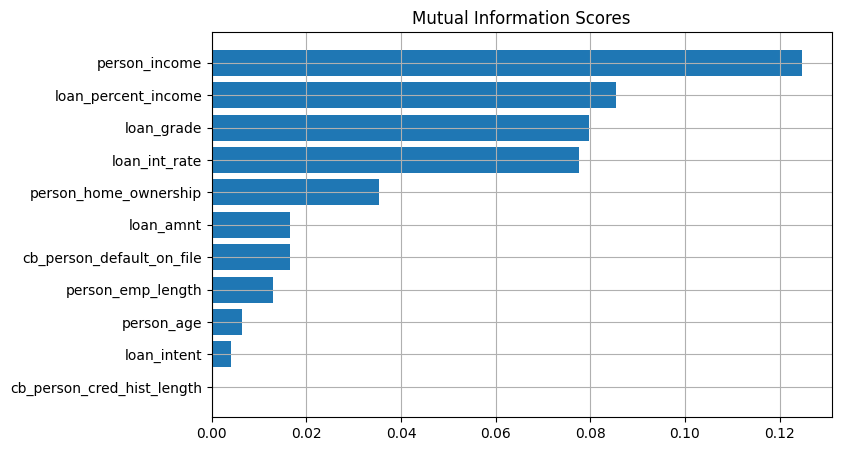

In [12]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    plt.grid()

df = train_df.copy()
mi_scores = make_mi_scores(df, df.pop('loan_status'))

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))


---

### Data cleaning

- Looking for outliers

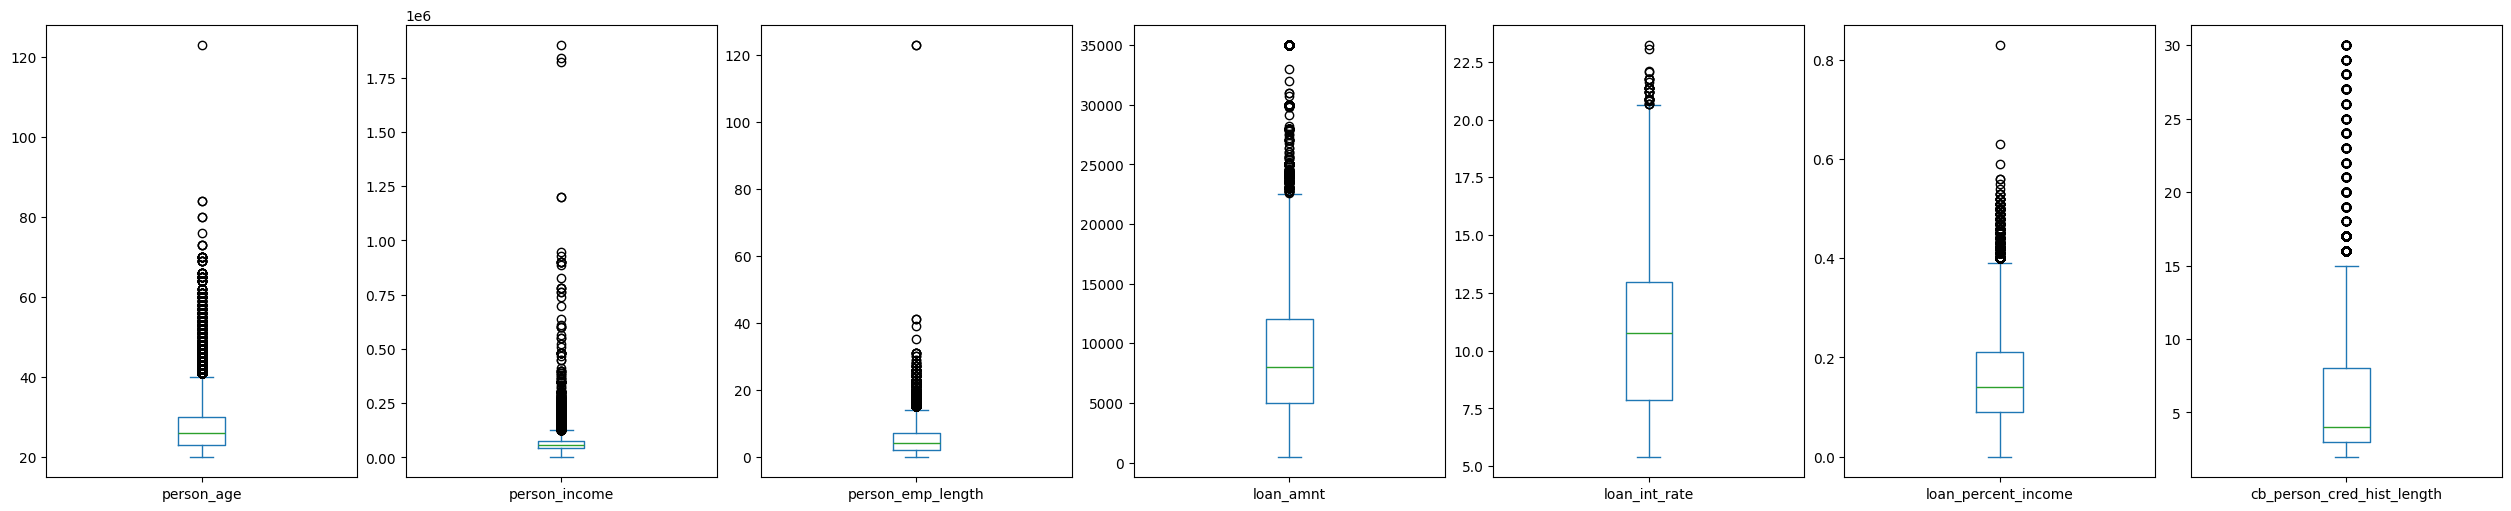

In [13]:
fig, axs = plt.subplots(1, 7, figsize=(25,5), constrained_layout=True)

for i, col in enumerate(['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']):
    train_df[col].plot.box(
        ax = axs[i],
    )

plt.show()

- Checking outliers

1. Age

In [14]:
age_outliers = train_df[train_df['person_age'] > 100]
age_outliers

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
47336,123,36000,MORTGAGE,7.0,PERSONAL,B,6700,10.75,0.18,N,4,0


This is likely a typing error, the oldest person in recorded history was 122 (<123), so let's just replace this value with NaN and the pipeline will change it to the mean later on.

In [15]:
train_df.loc[age_outliers.index, 'person_age'] = np.NaN

2. Employement time

In [16]:
emp_len_outliers = train_df[train_df['person_emp_length'] > 100]
emp_len_outliers

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
41079,28.0,60350,MORTGAGE,123.0,MEDICAL,D,25000,15.95,0.35,Y,6,1
49252,21.0,192000,MORTGAGE,123.0,VENTURE,B,20000,11.49,0.10,N,2,0


Well.. a 28 yo can't be working for 123 years right? let's replace this value for NaN and the pipeline will change it to: the age - the **median** (22) age when people start working later on.

In [17]:
train_df.loc[emp_len_outliers.index, 'person_emp_length'] = np.NaN

3. Loan % income

In [18]:
train_df[train_df['loan_percent_income'] > 0.6]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
49179,39.0,12000,RENT,0.0,PERSONAL,C,16000,10.78,0.83,N,12,1
56034,35.0,40000,OWN,1.0,HOMEIMPROVEMENT,B,25000,11.86,0.63,N,8,0


High values, but doesn't seem like any typos.

## Data setup

In [19]:
class DataPreprocessor:
    # === Static attributes
    # Categorical
    cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
    # Continuous
    con_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
    # Target
    target = 'loan_status'
    
    # Pre-processing Pipeline    
    def __init__(self, train_df: pd.DataFrame):
        self.df = train_df
        self.pipeline = self._make_pipeline()
        self.y = self.df.get(self.target)  # Target variable
        self.df = self._feature_eng(self.df)
        self.X = self._load_x(self.df)

    def _load_x(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.drop([self.target], axis=1) if self.target in df.columns else df  # Drop target
        return self.pipeline.fit_transform(df)  # Encode categorical columns

    def _make_pipeline(self) -> Pipeline:
        return Pipeline(
            [
                ('categorical_pipe', self._cat_pipeline()),
                ('continuous_pipe', self._con_pipeline()),
            ]
        )

    def _feature_eng(self, df: pd.DataFrame) -> pd.DataFrame:
        df['risk_score'] = df['loan_percent_income'] * df['loan_int_rate'] * (5 - df['loan_grade'].map({'A':5, 'B':4, 'C':3, 'D':2, 'E':1, 'F':0, 'G':0}))
        df['income_to_loan'] = df['person_income'] / df['loan_amnt']
        df['starting_credit_age'] = df['person_age'] - df['cb_person_cred_hist_length']
        df['cred_hist_len_cat'] = pd.cut(train_df['cb_person_cred_hist_length'], [0, 11, 19, np.inf], labels=[0, 1, 2]).astype(int)
        return df
    
    def _cat_pipeline(self) -> Pipeline:
        return make_pipeline(
            FunctionTransformer(self._replace_own),
            make_column_transformer(
                (SimpleImputer(strategy='most_frequent'), self.cat_cols),
                remainder='passthrough',
                verbose_feature_names_out=False
            ),
            make_column_transformer(
                (OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown="ignore"), ['person_home_ownership', 'cb_person_default_on_file', 'loan_intent']),
                (OrdinalEncoder(), ['loan_grade']),
                remainder='passthrough',
                verbose_feature_names_out=False,
            )
        ).set_output(transform="pandas")

    def _con_pipeline(self) -> Pipeline:
        return make_pipeline(
            make_column_transformer(
                (SimpleImputer(strategy="median"), self.con_cols),
                remainder='passthrough',
                verbose_feature_names_out=False,
            ),
            # No need for normalization or standardization, since we are using a tree based method (xgboost)
        ).set_output(transform='pandas')

    def _replace_own(self, df):
        df = df.copy()
        df['person_home_ownership'] = df['person_home_ownership'].replace({'OWN': 'OTHER'})
        return df
    
    def preprocess(self, df: pd.DataFrame) -> pd.DataFrame | tuple[pd.DataFrame, pd.Series]:
        y = self.df.get(self.target)
        X = df.drop([self.target], axis=1) if self.target in df.columns else df  # Drop target
        X = self._feature_eng(X)
        X = self.pipeline.transform(X)
        return X, y

In [20]:
preprocessor = DataPreprocessor(train_df)
train_x, train_y = preprocessor.X, preprocessor.y
test_x, test_y = preprocessor.preprocess(test_df)

In [21]:
print(train_x.shape, test_x.shape)

(58645, 22) (39098, 22)


In [22]:
train_x[train_x.isna().any(axis=1)]

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_RENT,...,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade,risk_score,income_to_loan,starting_credit_age,cred_hist_len_cat
id,,,,,,,,,,,,,,,,,,,,,
47336,26.0,36000.0,7.0,6700.0,10.75,0.18,4.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.935,5.373134,NaN,0


In [23]:
train_x.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_RENT,...,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade,risk_score,income_to_loan,starting_credit_age,cred_hist_len_cat
count,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,...,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58644.000000,58645.000000
mean,27.549203,6.404617e+04,4.696956,9217.556518,10.677874,0.159238,5.813556,0.423293,0.055026,0.521681,...,0.209242,0.107085,0.186444,0.170790,0.170705,1.066638,2.509220,9.467154,21.735642,0.099054
std,6.020330,3.793111e+04,3.899053,5563.807384,3.034697,0.091692,4.029196,0.494085,0.228033,0.499534,...,0.406771,0.309224,0.389468,0.376329,0.376254,1.046181,3.814866,10.191298,3.157244,0.321872
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.320000,-1.000000,0.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.777778,20.000000,0.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.278000,7.028571,21.000000,0.000000
75%,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.237600,11.200000,23.000000,0.000000
max,84.000000,1.900000e+06,41.000000,35000.000000,23.220000,0.830000,30.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,47.554500,1266.666667,62.000000,2.000000


In [24]:
train_x.dtypes

person_age                        float64
person_income                     float64
person_emp_length                 float64
loan_amnt                         float64
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length        float64
person_home_ownership_MORTGAGE    float64
person_home_ownership_OTHER       float64
person_home_ownership_RENT        float64
cb_person_default_on_file_Y       float64
loan_intent_DEBTCONSOLIDATION     float64
loan_intent_EDUCATION             float64
loan_intent_HOMEIMPROVEMENT       float64
loan_intent_MEDICAL               float64
loan_intent_PERSONAL              float64
loan_intent_VENTURE               float64
loan_grade                        float64
risk_score                        float64
income_to_loan                    float64
starting_credit_age               float64
cred_hist_len_cat                   int32
dtype: object

In [25]:
data_dmatrix = DMatrix(data=train_x, label=train_y)

params = {
    'random_state': 1,
    'n_estimators': 10000,
    'learning_rate': 0.01,
    'colsample_bytree': 0.6,
    'reg_lambda': 0.01,
    'max_depth': 4,
    'max_bin': 5000,
    'subsample': 0.95,
    'reg_alpha': 0.1,
}

xgb_cv = cv(
    dtrain=data_dmatrix,
    params=params,
    nfold=5,
    num_boost_round=10000,
    metrics="auc",
    as_pandas=True,
    seed=0,
)

c:\Users\12ped\anaconda3\envs\optuna\lib\site-packages\xgboost\core.py:158: UserWarning: [15:51:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [26]:
xgb_cv.iloc[-1]

train-auc-mean    0.986181
train-auc-std     0.000323
test-auc-mean     0.956627
test-auc-std      0.003167
Name: 9999, dtype: float64

In [28]:
xgb_clf = XGBClassifier(**params)
xgb_clf.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=5000,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10000, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [29]:
predictions = xgb_clf.predict(test_x)

In [30]:
submission_df = pd.DataFrame(predictions, index=test_x.index, columns=['loan_status'])
submission_df.to_csv('./submission.csv')

Text(0.5, 1.0, 'Feature Importance')

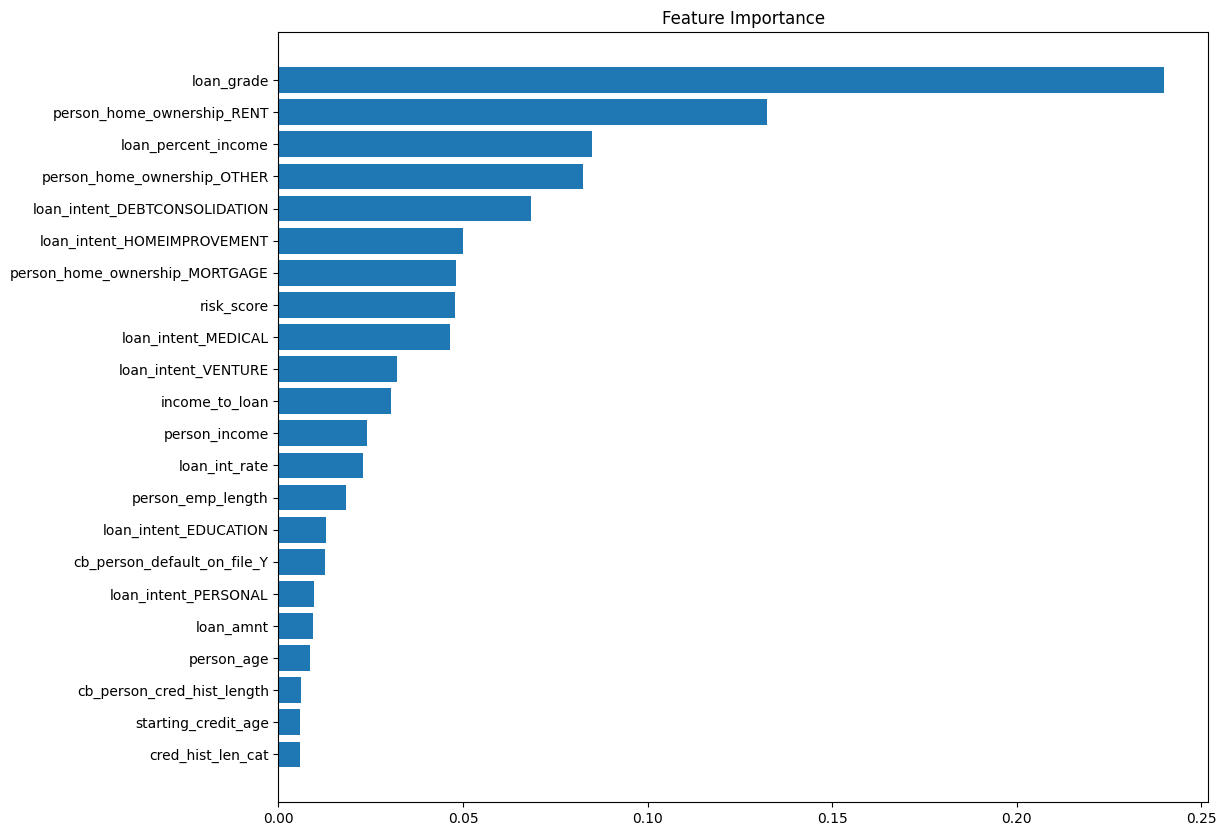

In [31]:
feature_importance = xgb_clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train_x.columns)[sorted_idx])
plt.title('Feature Importance')

## Note:

Many people concatenate the original dataset in the training set, but since I don't know if the model used to generate this dataset was trained using the original set I won't do that. I'm not concerned about competing for the best score in Kaggle, and this could be considered data leakage.